In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from control.modules.pcm import PcmControl, PcmParameters
from input_output.alarms import BaseAlarms
from input_output.base import Stamped
from input_output.definitions.simulation import Boundary, TemperatureBoundary
from input_output.modules.pcm import (
    PcmControlValues,
    PcmSensorValues,
    PcmSimulationInputs,
    PcmSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import pcm_path
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=29)
time_index = pl.datetime_range(
    start_time, start_time + duration, interval="1m", time_unit="us", eager=True
)

simulation_inputs = PcmSimulationInputs(
    pcm_producers_supply=Boundary(
        temperature=Stamped.stamp(70), flow=Stamped.stamp(80)
    ),
    pcm_consumers_supply=TemperatureBoundary(temperature=Stamped.stamp(60)),
    pcm_freshwater_supply=Boundary(
        temperature=Stamped.stamp(40), flow=Stamped.stamp(1)
    ),
)

control = PcmControl(PcmParameters())

pcm_model = SimulatorModel(
    fmu_path=pcm_path,
    sensor_values_cls=PcmSensorValues,
    control_values_cls=PcmControlValues,
    simulation_outputs_cls=PcmSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=BaseAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with pcm_model.executor() as executor:
    simulation = Simulator(pcm_model, executor)
    control.to_idle()

    result1 = await simulation.run(int(duration.total_seconds()))

    control.to_charging()

    result2 = await simulation.run(int(duration.total_seconds()))

    control.to_supplying()

    result3 = await simulation.run(int(duration.total_seconds()))

    control.to_boosting()

    result4 = await simulation.run(int(duration.total_seconds()))

    result = result1.vstack(result2).vstack(result3).vstack(result4)

[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 2026.25, mxstep steps taken before reaching tout.


/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_35847/2510081630.py:64: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  result = result1.vstack(result2).vstack(result3).vstack(result4)


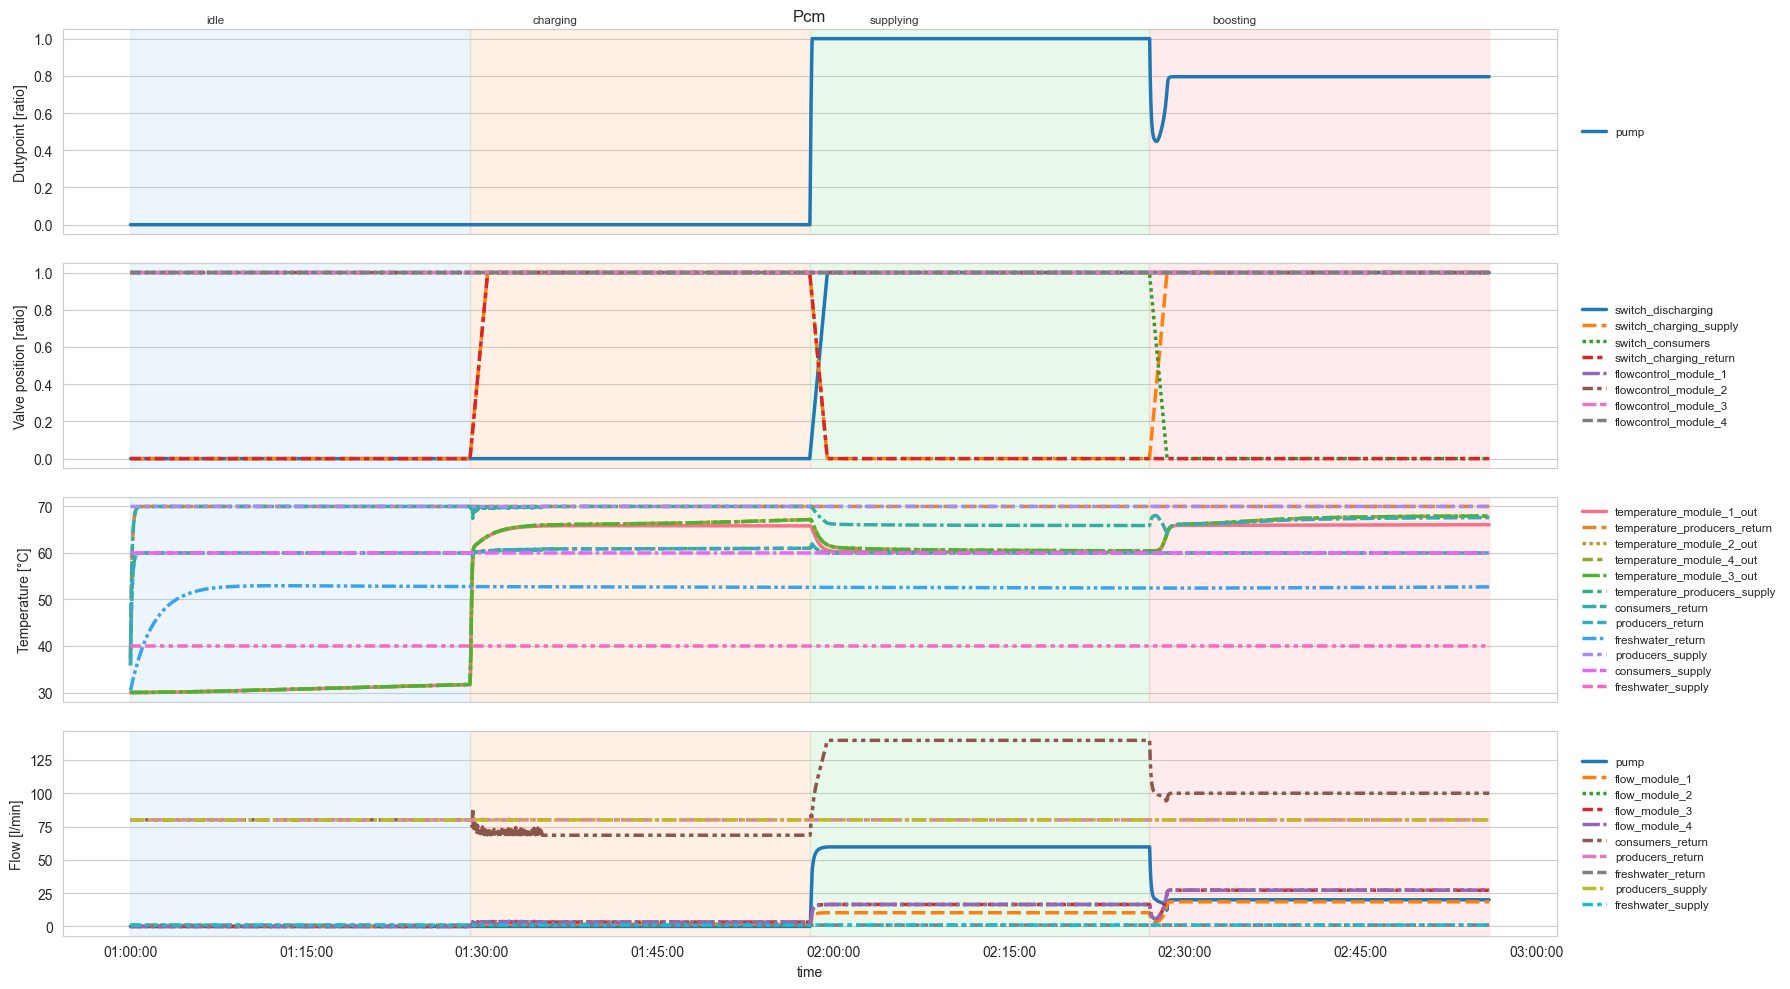

In [3]:
from analysis.analysis_utils import plot_result

plot_result(result, "plots/pcm.png");